# 다양한 OCR모델 비교하기

이미지로 부터 문자들을 인식하는 범용적인 프로그램을 만들어보자.  
사진같은 이미지에서 문자를 인식하다면 휴대폰으로 간편하게 얻은  
이미지로 부터 바로 번역이나 기타 정보등을 사용 할 수 있을 것이다.

## 0. 모듈 import

In [1]:
import os
import glob
import keras_ocr
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageDraw
from functools import reduce
from pytesseract import Output
from xml.etree.ElementTree import parse
from popeval.popEval import process, make_pair, _divide

## 1. 검증용 데이터셋 준비

학습의 평가를 위해서 annotation 정보가 있는 이미지가 필요하다.  
노가다로 직접 바운딩 박스의 정보를 만든 3장의 이미지와  
미리 정보가 있는 데이터 3장을 가지고 실험해보자.

annotatation 되어 있는 데이터의 출저는 다음과 같다.

출처 :http://www.iapr-tc11.org/mediawiki/index.php?title=KAIST_Scene_Text_Database

In [2]:
image_files = sorted(glob.glob('data/images/img_*'))
annotation_files = sorted(glob.glob('data/annotations/annotation_*'))

images = [Image.open(path) for path in image_files]

준비된 이미지들을 출력해보자.

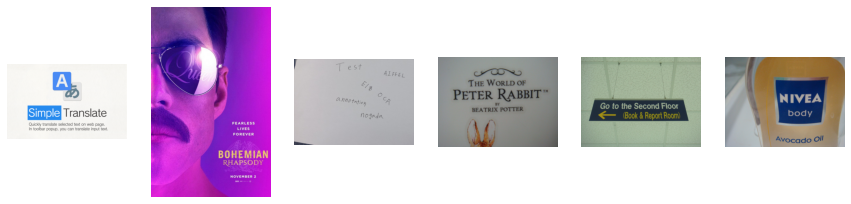

In [3]:
_, axes = plt.subplots(1, len(images), figsize=(15,15))
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')
    
plt.show()

각 준비된 annotation 정보들을 출력해보자.

In [4]:
with open(annotation_files[0], "r") as f:
        lines = f.readlines()
        
lines

['510\t100\t142\t152\tA\n',
 '228\t464\t340\t126\tSimple\n',
 '595\t468\t471\t107\tTranslate\n',
 '230\t619\t142\t51\tQuickly\n',
 '378\t622\t160\t46\ttranslate\n',
 '547\t622\t155\t43\tselected\n',
 '711\t625\t74\t37\ttext\n',
 '792\t627\t51\t36\ton\n',
 '851\t624\t83\t38\tweb\n',
 '940\t631\t110\t39\tpage.\n',
 '234\t672\t35\t38\tIn\n',
 '279\t675\t130\t38\ttoolbar\n',
 '418\t682\t133\t40\tpopup,\n',
 '560\t679\t77\t39\tyou\n',
 '643\t678\t75\t38\tcan\n',
 '724\t673\t164\t48\ttranslate\n',
 '895\t670\t97\t48\tinput\n',
 '998\t674\t82\t39\ttext.']

In [5]:
with open(annotation_files[-1], "r") as f:
        lines = f.readlines()
        
lines

['\ufeff<?xml version="1.0" encoding="utf-8" standalone="yes"?>\n',
 '<images>\n',
 '  <image>\n',
 '    <imageName>DSC03947.JPG</imageName>\n',
 '    <resolution x="640" y="480" />\n',
 '    <words>\n',
 '      <word x="285" y="181" width="237" height="74">\n',
 '        <character x="285" y="183" width="57" height="72" char="N" />\n',
 '        <character x="340" y="182" width="29" height="68" char="I" />\n',
 '        <character x="369" y="181" width="55" height="70" char="V" />\n',
 '        <character x="424" y="192" width="39" height="58" char="E" />\n',
 '        <character x="463" y="184" width="59" height="66" char="A" />\n',
 '      </word>\n',
 '      <word x="330" y="267" width="143" height="66">\n',
 '        <character x="330" y="267" width="39" height="51" char="b" />\n',
 '        <character x="369" y="282" width="33" height="37" char="o" />\n',
 '        <character x="402" y="269" width="33" height="51" char="d" />\n',
 '        <character x="439" y="279" width="34" he

.txt로 된 파일은 직접 만든 포맷이고, xml은 다운받은 포맷이다.  
각 포맷을 하나의 gt 포맷으로 변환시켜야한다.

In [6]:
def draw_boundingbox(img, vertices):
    draw = ImageDraw.Draw(img)
    vertices.append(vertices[0])
    draw.line(vertices, fill="red", width=5)
    return img

In [7]:
def write_format_line(f, vertices, word):
    for v in vertices:
        f.write(f'{int(v[0])} {int(v[1])} ')
    f.write(f'##::{word.lower()}\n')

In [8]:
def get_words_from_myformat(load_path):
    '''직접 작성한 좌표정보 포맷에서 정보를 추출한다.
    직사각형 박스는 (x   y   w   h   word)로 기록되어 있고,
    사다리꼴은 (@   x1   y1   ...  x4   y4   word)이며 @로 시작한다.
    단어 사이의 띄어쓰기가 있을수 있어서 구분은 탭(\t)으로만 하였다.'''
    vertices_list = []
    words = []
    
    with open(load_path, "r") as f:
        lines = f.readlines()
    
    for line in lines:
        tokens = line.split('\t')
        words.append(tokens[-1].split()[0])
        if tokens[0] == '@':     # 사다리꼴 검출
            vertices_list.append([(int(tokens[i]), int(tokens[i+1])) for i in range(1,9,2)])
        else:                   # 직사각형 검출
            x, y, w, h = map(int, tokens[:4])
            vertices_list.append([(x,y), (x+w,y), (x+w,y+h), (x,y+h)])
    return vertices_list, words


def get_words_from_xml(load_path):
    '''준비된 xml 파일에서 정보를 추출한다.'''
    
    tree = parse(load_path)
    
    words = []
    vertices_list = []

    for word in tree.find('image').find('words').findall('word'):
        words.append(''.join([x.attrib['char'] for x in word.findall('character')]))
        
        x, y, w, h = map(int, word.attrib.values())
        vertices_list.append([(x,y), (x+w,y), (x+w,y+h), (x,y+h)])        
    return vertices_list, words


def convert_to_gt_format_and_draw_regions(img, load_path, save_path):
    if os.path.splitext(load_path)[1] == '.xml':
        vertices_list, words = get_words_from_xml(load_path)
    else:
        vertices_list, words = get_words_from_myformat(load_path)

    with open(save_path, "w") as f:
        for vertices, word in zip(vertices_list, words):
            draw_boundingbox(img, vertices)
            write_format_line(f, vertices, word)

위에서 구현한 함수들을 사용해서 정보들을 새롭게 포맷하면서  
미리 준비된 이미지에 어떻게 바운딩 박스가 씌어지는지 그려보자.

In [9]:
gt_files = []

for i, load_path in enumerate(annotation_files):
    gt_files.append(f'data/annotations/GT_{i:03d}.txt')     # 포맷에 맞게 저장할 경로
    convert_to_gt_format_and_draw_regions(images[i], load_path, gt_files[-1])

통일된 gt 포맷을 출력해보자.

In [10]:
with open(gt_files[0], "r") as f:
        lines = f.readlines()
        
lines

['510 100 652 100 652 252 510 252 510 100 ##::a\n',
 '228 464 568 464 568 590 228 590 228 464 ##::simple\n',
 '595 468 1066 468 1066 575 595 575 595 468 ##::translate\n',
 '230 619 372 619 372 670 230 670 230 619 ##::quickly\n',
 '378 622 538 622 538 668 378 668 378 622 ##::translate\n',
 '547 622 702 622 702 665 547 665 547 622 ##::selected\n',
 '711 625 785 625 785 662 711 662 711 625 ##::text\n',
 '792 627 843 627 843 663 792 663 792 627 ##::on\n',
 '851 624 934 624 934 662 851 662 851 624 ##::web\n',
 '940 631 1050 631 1050 670 940 670 940 631 ##::page.\n',
 '234 672 269 672 269 710 234 710 234 672 ##::in\n',
 '279 675 409 675 409 713 279 713 279 675 ##::toolbar\n',
 '418 682 551 682 551 722 418 722 418 682 ##::popup,\n',
 '560 679 637 679 637 718 560 718 560 679 ##::you\n',
 '643 678 718 678 718 716 643 716 643 678 ##::can\n',
 '724 673 888 673 888 721 724 721 724 673 ##::translate\n',
 '895 670 992 670 992 718 895 718 895 670 ##::input\n',
 '998 674 1080 674 1080 713 998 713 998 

기존의 이미지에 바운딩 박스가 새롭게 그려진 이미지를 출력해보자.

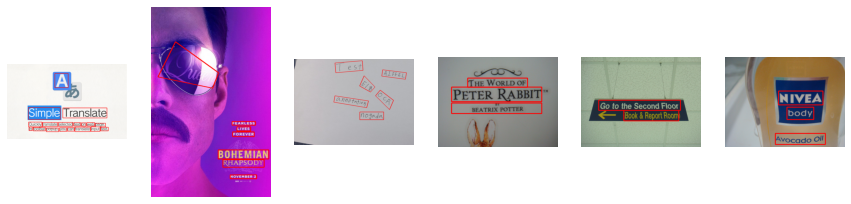

In [11]:
_, axes = plt.subplots(1, len(images), figsize=(15,15))
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')
    
plt.show()

## 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

이제 3가지의 OCR모델들을 사용해서 준비된 이미지들로 테스트해보자.

### 평가방법

아래 출처에서 나온 방법으로 각 이미지에 대한 precision, recall을  
100점 만점으로 구하여 평가한다.

출처 : https://github.com/naver/popeval

In [12]:
def evaluate(gt_files, pred_files, dontcare_text='###'):
    removed_gt_char_count = 0
    precision_list = []
    recall_list = []

    total_removed_gt_char_count = 0
    total_pred_char_count = 0
    total_gt_chars_count = 0

    # 기존 멀티프로세스로 되어있던것을 변경하였다. 느리다면 기존 코드를 참고해서 변경할것.
    for result in map(process, gt_files, pred_files, [dontcare_text]*len(pred_files)):
        try:
            precision, recall, removed_gt_char_count, pred_char_count, gt_char_count = result
            total_removed_gt_char_count += removed_gt_char_count
            total_pred_char_count += pred_char_count
            total_gt_chars_count += gt_char_count
            precision_list.append(precision)
            recall_list.append(recall)
        except Exception as e:
            print(e)

    precision_for_char = _divide(
        float(total_removed_gt_char_count), float(total_pred_char_count))
    recall_for_char = _divide(
        float(total_removed_gt_char_count), float(total_gt_chars_count))
    #precision_avr = _divide(reduce(lambda x, y: x + y, precision_list, 0), len(precision_list))
    #recall_avr = _divide(reduce(lambda x, y: x + y, recall_list, 0), len(recall_list))
    perf = _divide(2*(precision_for_char*recall_for_char),
                   (precision_for_char + recall_for_char))

    print(' num | precision |  recall  |')
    for i, (precision, recall) in enumerate(zip(precision_list, recall_list)):
        print(f' {i:03d} | {precision:f}  | {recall:f} |')
    print("======================")
    return {'pfc':precision_for_char, 'rfc':recall_for_char, 'h':perf, 'p_list':precision_list,'r_list': recall_list}

### Google OCR API

In [13]:
def detect_text(image_path, save_path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    
    client= vision.ImageAnnotatorClient()

    with io.open(image_path, 'rb') as f:
        content= f.read()

    image= vision.Image(content=content)

    response= client.text_detection(image=image)
    texts= response.text_annotations
    
    words = [text.description for text in texts]
    print('<인식한 문자들>')
    print(words)
    
    D_files = []
    img = Image.open(path)
    
    with open(save_path, "w") as f:
        for i, vertices in enumerate([t.bounding_poly.vertices for t in texts]):
            vertices = [(v.x, v.y) for v in vertices]
            draw_boundingbox(img, vertices)
            if i != 0:
                write_format_line(f, vertices, words[i])
        
    print('\n<박스로 검출 된 이미지 영역>')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return img

<인식한 문자들>
['A\nSimple Translate\nQuickly translate selected text on web page.\nIn toolbar popup, you can translate input text.\n', 'A', 'Simple', 'Translate', 'Quickly', 'translate', 'selected', 'text', 'on', 'web', 'page.', 'In', 'toolbar', 'popup,', 'you', 'can', 'translate', 'input', 'text.']

<박스로 검출 된 이미지 영역>


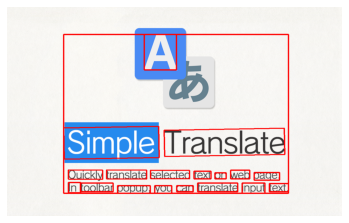

<인식한 문자들>
['FEARLESS\nLIVES\nFOREVER\nBOHEMIAN\nRHAPSODY\nNOVEMBER 2\n', 'FEARLESS', 'LIVES', 'FOREVER', 'BOHEMIAN', 'RHAPSODY', 'NOVEMBER', '2']

<박스로 검출 된 이미지 영역>


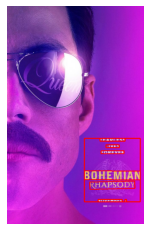

<인식한 문자들>
['Test\nAI FFEL\nEl8 O CR\nannotation\nno gada\n', 'Test', 'AI', 'FFEL', 'El8', 'O', 'CR', 'annotation', 'no', 'gada']

<박스로 검출 된 이미지 영역>


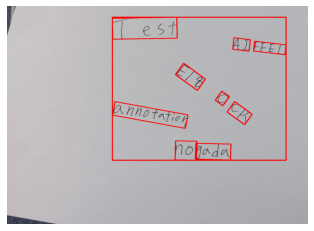

<인식한 문자들>
['THE WORLD OF\nPETER RABBIT™\nBY\nBEATRIX POTTER\n', 'THE', 'WORLD', 'OF', 'PETER', 'RABBIT™', 'BY', 'BEATRIX', 'POTTER']

<박스로 검출 된 이미지 영역>


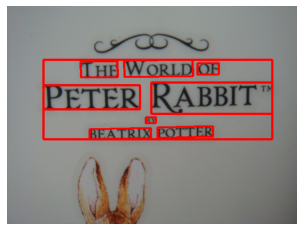

<인식한 문자들>
['Go to the Second Floor\n-(Book & Report Room)\n', 'Go', 'to', 'the', 'Second', 'Floor', '-(Book', '&', 'Report', 'Room)']

<박스로 검출 된 이미지 영역>


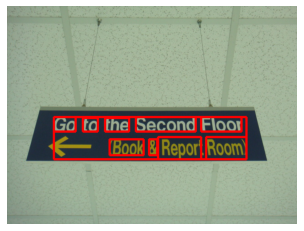

<인식한 문자들>
['Avocado Oil\nNIVEA\nbody\n', 'Avocado', 'Oil', 'NIVEA', 'body']

<박스로 검출 된 이미지 영역>


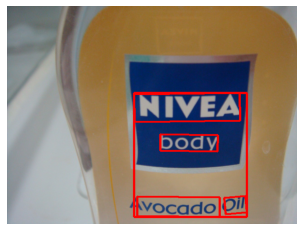

In [14]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  'data/my_google_api_key.json'

google_files = []

for i, path in enumerate(image_files):
    google_files.append(f'data/annotations/google_{i:03d}.txt')  # 구글 ocr 결과
    img = detect_text(path, google_files[-1])
    img.save(f'data/images/google_{i:03d}.png', 'PNG')

결과가 좋게 나온것 같다.  
위에서 만들어진 google annotation파일을 하나 출력해보자.

In [15]:
with open(google_files[0], "r") as f:
        lines = f.readlines()
        
lines

['524 108 647 108 647 243 524 243 524 108 ##::a\n',
 '216 464 579 458 581 577 218 583 216 464 ##::simple\n',
 '600 473 1059 465 1061 565 602 573 600 473 ##::translate\n',
 '234 624 365 625 365 660 234 659 234 624 ##::quickly\n',
 '380 624 533 625 533 659 380 658 380 624 ##::translate\n',
 '548 625 697 626 697 658 548 657 548 625 ##::selected\n',
 '714 629 779 629 779 658 714 658 714 629 ##::text\n',
 '794 635 837 635 837 658 794 658 794 635 ##::on\n',
 '854 625 927 625 927 658 854 658 854 625 ##::web\n',
 '944 634 1041 634 1041 663 944 663 944 634 ##::page.\n',
 '234 672 281 672 281 711 234 711 234 672 ##::in\n',
 '280 674 405 674 405 707 280 707 280 674 ##::toolbar\n',
 '422 684 547 684 547 713 422 713 422 684 ##::popup,\n',
 '564 684 629 684 629 713 564 713 564 684 ##::you\n',
 '648 684 711 684 711 707 648 707 648 684 ##::can\n',
 '728 674 881 674 881 707 728 707 728 674 ##::translate\n',
 '898 674 985 674 985 713 898 713 898 674 ##::input\n',
 '1002 676 1075 676 1075 707 1002 707 10

gt 포맷으로 잘 만들어졌다.  
그러면 이제 gt와 만들어진 pred를 비교해서 점수로 평가해보자.

In [16]:
google_eval = evaluate(gt_files, google_files)
print("precision, recall, H:")
print("%0.1f, %0.1f, %0.1f"%(100.*google_eval['pfc'], 100.*google_eval['rfc'], 100.*google_eval['h']))

 num | precision |  recall  |
 000 | 1.000000  | 1.000000 |
 001 | 1.000000  | 0.900000 |
 002 | 0.968750  | 0.968750 |
 003 | 0.918919  | 1.000000 |
 004 | 0.888889  | 1.000000 |
 005 | 1.000000  | 1.000000 |
precision, recall, H:
97.0, 97.7, 97.3


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


매우 높은 정확도를 보여준다.  
틀린부분을 보면 002번에서 OCR에서 'O'를 숫자 '0'으로 판별하면서 1개 틀렸고,  
003번은 오히려 gt에 빠져있던 '™'이라는 단어까지 인식하였다.  
그래서 003의 경우 recall이 1.0이고 precision이 떨어진다.  
이건 오히려 준비된 이미지에 대한 gt annotation정보가 틀렸다고 보는게 맞다.

### keras-ocr

In [17]:
pipeline = keras_ocr.pipeline.Pipeline()

ocr_images = [keras_ocr.tools.read(path) for path in image_files]
prediction_groups = [pipeline.recognize([path]) for path in image_files]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


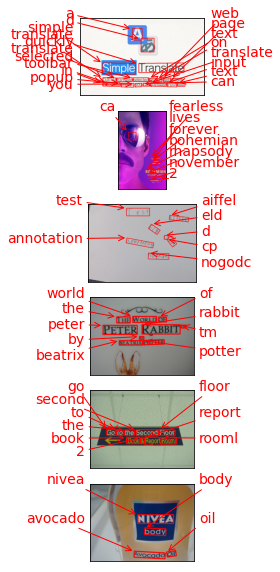

In [18]:
fig, axs = plt.subplots(nrows=len(ocr_images), figsize=(5, 10))
for i, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=ocr_images[i], predictions=prediction_groups[i][0], ax=ax)

In [19]:
keras_files = []

for i, img_info in enumerate(prediction_groups):
    img = Image.open(image_files[i])
    keras_files.append(f'data/annotations/keras_{i:03d}.txt')
    
    with open(keras_files[-1], "w") as f:
        for box_info in img_info[0]:
            write_format_line(f, box_info[1], box_info[0])
            draw_boundingbox(img, list(map(tuple, box_info[1].astype(int))))
    
    img.save(f'data/images/keras_{i:03d}.png', 'PNG')

In [20]:
with open(keras_files[0], "r") as f:
        lines = f.readlines()
        
lines

['537 116 636 116 636 236 537 236 ##::a\n',
 '625 217 758 217 758 358 625 358 ##::d\n',
 '233 470 567 475 565 587 231 582 ##::simple\n',
 '602 475 1064 471 1065 566 602 570 ##::translate\n',
 '233 622 369 624 368 668 233 667 ##::quickly\n',
 '545 623 702 623 702 661 545 661 ##::selected\n',
 '853 625 928 625 928 662 853 662 ##::web\n',
 '375 626 535 622 536 661 376 664 ##::translate\n',
 '711 627 783 627 783 661 711 661 ##::text\n',
 '940 630 1044 627 1045 668 941 671 ##::page\n',
 '793 631 840 631 840 661 793 661 ##::on\n',
 '276 671 410 673 409 711 275 709 ##::toolbar\n',
 '723 672 885 673 884 711 723 709 ##::translate\n',
 '893 673 990 675 989 717 893 715 ##::input\n',
 '233 676 267 676 267 708 233 708 ##::in\n',
 '998 676 1075 676 1075 710 998 710 ##::text\n',
 '646 678 714 678 714 709 646 709 ##::can\n',
 '420 678 551 680 551 719 419 717 ##::popup\n',
 '562 682 633 679 635 714 564 718 ##::you\n']

In [21]:
keras_eval = evaluate(gt_files, keras_files)
print("precision, recall, H:")
print("%0.1f, %0.1f, %0.1f"%(100.*keras_eval['pfc'], 100.*keras_eval['rfc'], 100.*keras_eval['h']))

 num | precision |  recall  |
 000 | 0.989130  | 0.968085 |
 001 | 0.957447  | 0.900000 |
 002 | 0.812500  | 0.812500 |
 003 | 0.894737  | 1.000000 |
 004 | 0.941176  | 1.000000 |
 005 | 1.000000  | 1.000000 |
precision, recall, H:
94.3, 94.6, 94.5


직접 준비한 이미지에 대해서는 살짝 틀리지만,  
카이스트 데이터들에 recall은 1.0으로 google과 마찬가지로  
오히려 더 자세하게 인식해서 저런 점수가 나온것 같다.

### Tesseract

In [22]:
def crop_word_regions(image):
    custom_oem_psm_config = r'--oem 3 --psm 3'

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )

    top_level = max(recognized_data['level'])
    cropped_images = []
    vertices_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]

        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            vertices_list.append([(left,top), (left+width,top), 
                                  (left+width,top+height), (left,top+height)])
            
            cropped_image = image.crop((left, top, left+width, top+height))
            cropped_images.append(cropped_image)
            
    return cropped_images, vertices_list

In [23]:
def recognize_images(cropped_images):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    words = []
    
    for image in cropped_images:
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )    
        words.append(recognized_data['text'].split('\n')[0])
    
    print(words)
    return words

In [24]:
def predict_tesseract(image_path, save_path):
    img = Image.open(image_path)
    
    cropped_images, vertices_list = crop_word_regions(img)
    words = recognize_images(cropped_images)

    with open(save_path, "w") as f:
        for word, vertices in zip(words, vertices_list):
            write_format_line(f, vertices, word)
    
    for vertices in vertices_list:
        draw_boundingbox(img, vertices)
        
    print('\n<박스로 검출 된 이미지 영역>')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img.save(f'data/images/tesseract_{i:03d}.png', 'PNG')

['Translate', 'Quickly', 'transiate', 'selected', 'Text', 'ON', 'wepd', 'Dade.', 'In', 'toolbar', 'DODUD,', 'YOu', 'Can', 'translate', 'input', 'TEXT.']

<박스로 검출 된 이미지 영역>


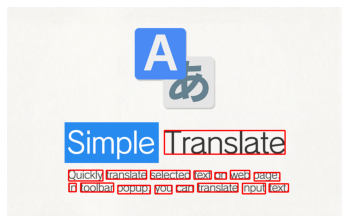

['4', '\x0c', 'aw: y-ss', 'Aso', 'FOR', '=', 'Ty', 'ER', 'BOHEMIAN', 'RHAPSODY', 'NOVEMBER', '2']

<박스로 검출 된 이미지 영역>


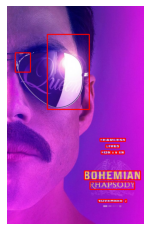

['} a Fee']

<박스로 검출 된 이미지 영역>


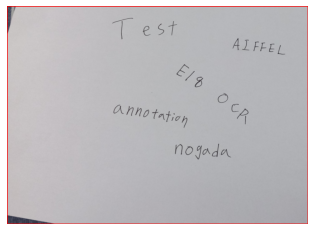

['CH Go, 2', 'THE', 'WoORLD', 'OF', 'PETER', 'RABBIT ”', 'BY', 'BEATRIX', 'POTTER', '\x0c']

<박스로 검출 된 이미지 영역>


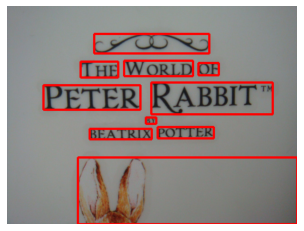

["'eTe", 'to the Second', 'Floor', 'Go to ys) Seer ae']

<박스로 검출 된 이미지 영역>


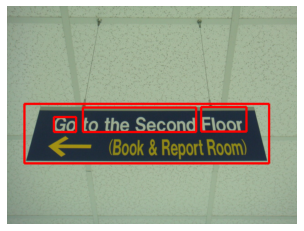

['pve', '\x0c', '0 Ol']

<박스로 검출 된 이미지 영역>


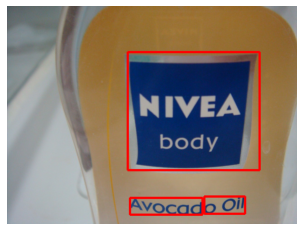

In [25]:
tesseract_files = []

for i, path in enumerate(image_files):
    tesseract_files.append(f'data/annotations/tesseract_{i:03d}.txt')
    predict_tesseract(path, tesseract_files[-1])

In [26]:
with open(tesseract_files[0], "r") as f:
        lines = f.readlines()
        
lines

['601 474 1062 474 1062 564 601 564 ##::translate\n',
 '235 625 366 625 366 666 235 666 ##::quickly\n',
 '379 626 533 626 533 659 379 659 ##::transiate\n',
 '548 626 699 626 699 659 548 659 ##::selected\n',
 '714 628 780 628 780 659 714 659 ##::text\n',
 '794 634 838 634 838 659 794 659 ##::on\n',
 '853 626 927 626 927 659 853 659 ##::wepd\n',
 '944 634 1042 634 1042 666 944 666 ##::dade.\n',
 '236 675 264 675 264 707 236 707 ##::in\n',
 '281 674 407 674 407 708 281 708 ##::toolbar\n',
 '423 683 547 683 547 715 423 715 ##::dodud,\n',
 '565 683 630 683 630 715 565 715 ##::you\n',
 '647 683 712 683 712 708 647 708 ##::can\n',
 '728 675 882 675 882 708 728 708 ##::translate\n',
 '899 675 987 675 987 715 899 715 ##::input\n',
 '1001 677 1075 677 1075 708 1001 708 ##::text.\n']

In [27]:
tesseract_eval = evaluate(gt_files, tesseract_files)
print("precision, recall, H:")
print("%0.1f, %0.1f, %0.1f"%(100.*tesseract_eval['pfc'], 100.*tesseract_eval['rfc'], 100.*tesseract_eval['h']))

 num | precision |  recall  |
 000 | 0.909091  | 0.851064 |
 001 | 0.739130  | 0.680000 |
 002 | 0.571429  | 0.125000 |
 003 | 0.708333  | 1.000000 |
 004 | 0.564103  | 0.687500 |
 005 | 0.500000  | 0.210526 |
precision, recall, H:
75.4, 68.2, 71.6


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


위의 2개의 모델과 다르게 성능이 좋지 않다.  
특히 글자의 크기에 따라 그 인식하는 정도차이가 심한것 같다.

## 3. 테스트 결과 정리

마지막으로 각 모델과 이미지에 대한것을 출력해서 비교해 보자.

In [28]:
def show_images(axs, images, e, name):
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{name} P:{round(e['p_list'][i], 3)}, R:{round(e['r_list'][i], 3)}")

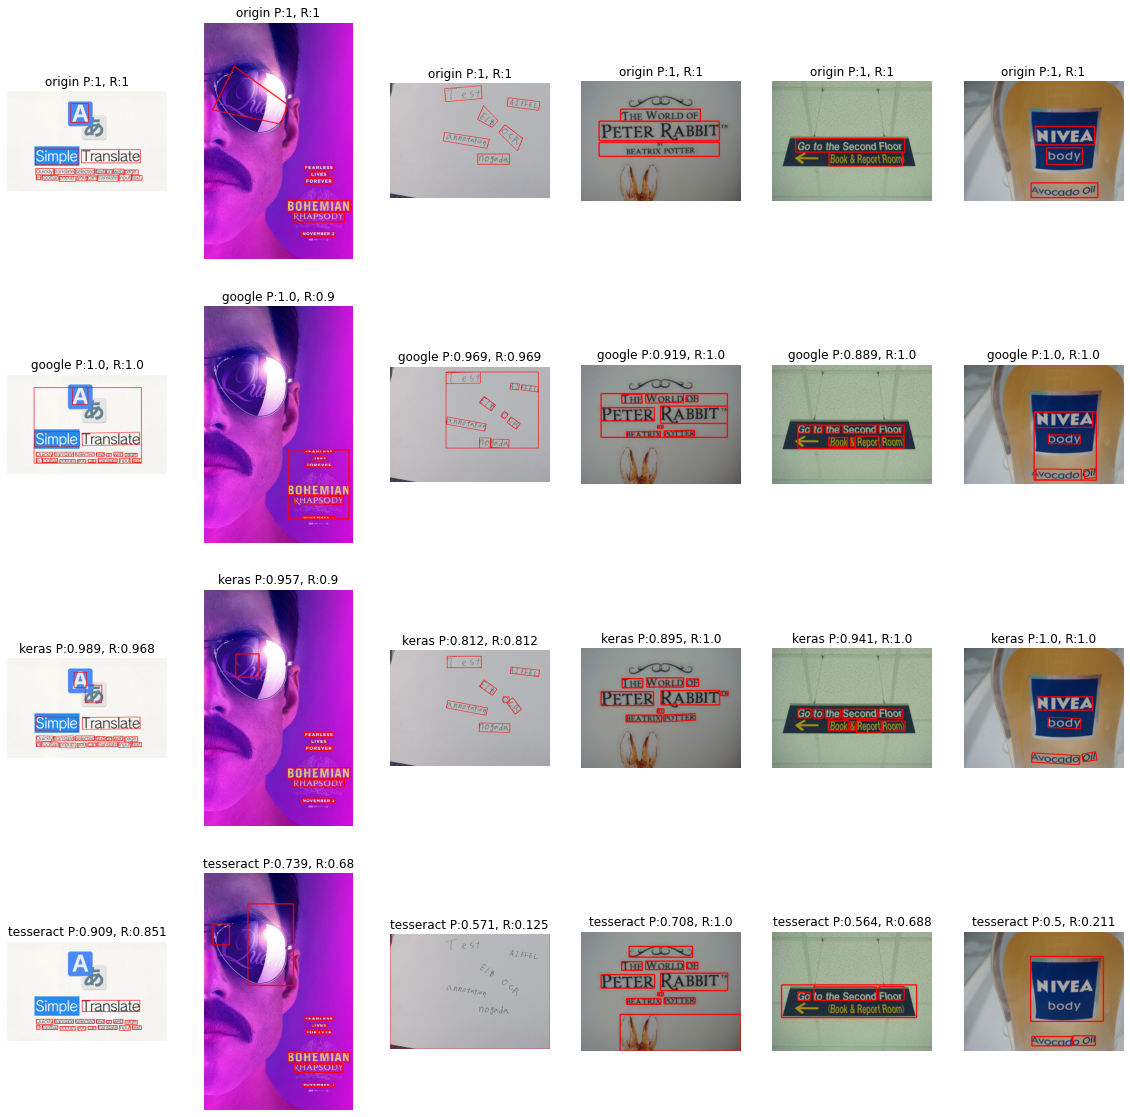

In [29]:
keras_images = [Image.open(path) for path in sorted(glob.glob('data/images/keras*.png'))]

names = ['origin', 'google', 'keras', 'tesseract']
evals = [{'p_list':[1,]*6, 'r_list':[1,]*6}, google_eval, keras_eval, tesseract_eval]

fig, axes = plt.subplots(4, 6, figsize=(20, 20))
for i, axs in enumerate(axes):
    if i != 0:
        images = [Image.open(path) for path in sorted(glob.glob(f'data/images/{names[i]}*'))]
    show_images(axs, images, evals[i], names[i])

## 4. 결과 분석과 결론 제시

휴대폰 등으로 부터 찍은 사진에서 문자를 얻어 내는 프로그램을 만들어보았다.  
여기에 번역이나, 검색등의 활용적인 추가 기능을 많이 적용할 수 있을 것이다.  

google, keras, tesseract 3가지 모델로 실험한 결과 google이 97점으로 가장 점수가 높았다.  
tesseract는 글자크기에 따라 인식 못하거나 잘못 인식하는 경우가 많았고,  
keras는 google과 거의 비슷한 결과가 나왔다.  
바운딩 박스 검출까지만 보자면 keras가 더 좋은 것 같기도 하다.  
다만 문자 인식 부분에서는 google이 더 좋은 성능을 내 주었다.

물론 아직 영어 'O'를 숫자 '0'으로 판별하기도 하는 문제가 있는 것 같다.